In [146]:
# Loading required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

In [53]:
# loading and exploring the data

In [54]:
# df = pd.read_csv("METABRIC_RNA_Mutation.csv") 
# Throws error since Columns (678,688,690,692) contains mixed data types (texts and numbers).
# This confuses pandas when trying to automatically determine the data type.

In [55]:
# To let the pandas read the file in chunks and determine the correct type
df = pd.read_csv("METABRIC_RNA_Mutation.csv", low_memory=False) 

In [56]:
# Display the first few rows
print(df.head())

   patient_id  age_at_diagnosis type_of_breast_surgery    cancer_type  \
0           0             75.65             MASTECTOMY  Breast Cancer   
1           2             43.19      BREAST CONSERVING  Breast Cancer   
2           5             48.87             MASTECTOMY  Breast Cancer   
3           6             47.68             MASTECTOMY  Breast Cancer   
4           8             76.97             MASTECTOMY  Breast Cancer   

                        cancer_type_detailed cellularity  chemotherapy  \
0           Breast Invasive Ductal Carcinoma         NaN             0   
1           Breast Invasive Ductal Carcinoma        High             0   
2           Breast Invasive Ductal Carcinoma        High             1   
3  Breast Mixed Ductal and Lobular Carcinoma    Moderate             1   
4  Breast Mixed Ductal and Lobular Carcinoma        High             1   

  pam50_+_claudin-low_subtype  cohort er_status_measured_by_ihc  ... mtap_mut  \
0                 claudin-low     1

In [57]:
# check column names
print(df.columns)

Index(['patient_id', 'age_at_diagnosis', 'type_of_breast_surgery',
       'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy',
       'pam50_+_claudin-low_subtype', 'cohort', 'er_status_measured_by_ihc',
       ...
       'mtap_mut', 'ppp2cb_mut', 'smarcd1_mut', 'nras_mut', 'ndfip1_mut',
       'hras_mut', 'prps2_mut', 'smarcb1_mut', 'stmn2_mut', 'siah1_mut'],
      dtype='object', length=693)


In [58]:
# check for missing values
print(df.isnull().sum())

patient_id                 0
age_at_diagnosis           0
type_of_breast_surgery    22
cancer_type                0
cancer_type_detailed      15
                          ..
hras_mut                   0
prps2_mut                  0
smarcb1_mut                0
stmn2_mut                  0
siah1_mut                  0
Length: 693, dtype: int64


In [59]:
# Summary of the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 693 entries, patient_id to siah1_mut
dtypes: float64(498), int64(5), object(190)
memory usage: 10.1+ MB
None


In [60]:
# Finding the target variable

In [61]:
# Checking for unique values in the "chemotherapy" column
print(df["chemotherapy"].value_counts())  

# This column only shows who received chemotherapy—it does NOT tell us how they responded.
# Not useful as a target variable

chemotherapy
0    1508
1     396
Name: count, dtype: int64


In [62]:
# The "pam50_+_claudin-low_subtype" column may indicate how a patient responds to treatment based on molecular subtypes.
print(df["pam50_+_claudin-low_subtype"].value_counts())

# The output shows categorized patient groups, which corelates with treatment outcomes
# The different subtypes (LumA, LumB, Her2, etc.) are not direct treatment responses, but they do influence how patients respond to treatment.

pam50_+_claudin-low_subtype
LumA           679
LumB           461
Her2           220
claudin-low    199
Basal          199
Normal         140
NC               6
Name: count, dtype: int64


In [63]:
# Checking for columns that may indicate survival status

for col in df.columns:
    if "survival" in col.lower() or "recurrence" in col.lower():
        print(col)


overall_survival_months
overall_survival


In [64]:
# "overall_survival_months" = How long the patient survived after treatment.
# "overall_survival" (likely 0 = deceased, 1 = alive) = If the patient is alive or not.

# If a patient survived longer, the treatment likely worked well.
# If a patient had poor survival, they likely did not respond well to treatment.

# Best target variable: "overall_survival"
# This gives a clear indicator of whether the treatment was effective.
# You can predict if a patient is likely to survive based on gene expression & treatment.

In [65]:
print(df["overall_survival"].value_counts())

overall_survival
0    1103
1     801
Name: count, dtype: int64


In [66]:
# converting into treatment response labels
df["treatment_response"] = df["overall_survival"].map({1: "Responder", 0: "Non-Responder"})
print(df["treatment_response"].value_counts())

treatment_response
Non-Responder    1103
Responder         801
Name: count, dtype: int64


In [67]:
# Defining Features (X) and Target (y) variables

# Features for prediction: (Clinical attributes):
# "age_at_diagnosis", "type_of_breast_surgery", "pam50_+_claudin-low_subtype", "chemotherapy"

# Gene expression data (top genes are selected later)

In [68]:
# Define target variable (treatment response)
df["treatment_response"] = df["overall_survival"]

In [69]:
# Select features
features = ["age_at_diagnosis", "chemotherapy", "pam50_+_claudin-low_subtype"]

In [70]:
# Define X (features) and y (target)
X = df[features]
y = df["treatment_response"]

In [71]:
# check for missing values
print(X.isnull().sum())

age_at_diagnosis               0
chemotherapy                   0
pam50_+_claudin-low_subtype    0
dtype: int64


In [100]:
# Data Preprocessing

In [102]:
# Drop patient IDs and any irrelevant metadata
df = df.drop(columns=["patient_id"])

In [103]:
# Handle missing values
# Count missing values per column
print(df.isnull().sum())

age_at_diagnosis           0
type_of_breast_surgery    22
cancer_type                0
cancer_type_detailed      15
cellularity               54
                          ..
prps2_mut                  0
smarcb1_mut                0
stmn2_mut                  0
siah1_mut                  0
treatment_response         0
Length: 693, dtype: int64


In [104]:
# Drop rows with missing values OR fill them
df = df.dropna()  # OR use df.fillna(df.mean()) for numeric columns

In [105]:
# Check again
print(df.isnull().sum())

age_at_diagnosis          0
type_of_breast_surgery    0
cancer_type               0
cancer_type_detailed      0
cellularity               0
                         ..
prps2_mut                 0
smarcb1_mut               0
stmn2_mut                 0
siah1_mut                 0
treatment_response        0
Length: 693, dtype: int64


In [111]:
# To identify the gene columns in the DataFrame (which appear to be columns ending in "_mut" such as 'mtap_mut', 'ppp2cb_mut', 'smarcd1_mut', etc.), we can filter out the columns that have the suffix _mut or any other pattern that represents gene expression data.

In [113]:
# Filter gene columns by suffix
gene_columns = [col for col in df.columns if col.endswith('_mut')]
print(gene_columns)

['pik3ca_mut', 'tp53_mut', 'muc16_mut', 'ahnak2_mut', 'kmt2c_mut', 'syne1_mut', 'gata3_mut', 'map3k1_mut', 'ahnak_mut', 'dnah11_mut', 'cdh1_mut', 'dnah2_mut', 'kmt2d_mut', 'ush2a_mut', 'ryr2_mut', 'dnah5_mut', 'herc2_mut', 'pde4dip_mut', 'akap9_mut', 'tg_mut', 'birc6_mut', 'utrn_mut', 'tbx3_mut', 'col6a3_mut', 'arid1a_mut', 'lama2_mut', 'notch1_mut', 'cbfb_mut', 'ncor2_mut', 'col12a1_mut', 'col22a1_mut', 'pten_mut', 'akt1_mut', 'atr_mut', 'thada_mut', 'ncor1_mut', 'stab2_mut', 'myh9_mut', 'runx1_mut', 'nf1_mut', 'map2k4_mut', 'ros1_mut', 'lamb3_mut', 'arid1b_mut', 'erbb2_mut', 'sf3b1_mut', 'shank2_mut', 'ep300_mut', 'ptprd_mut', 'usp9x_mut', 'setd2_mut', 'setd1a_mut', 'thsd7a_mut', 'afdn_mut', 'erbb3_mut', 'rb1_mut', 'myo1a_mut', 'alk_mut', 'fanca_mut', 'adgra2_mut', 'ubr5_mut', 'pik3r1_mut', 'myo3a_mut', 'asxl2_mut', 'apc_mut', 'ctcf_mut', 'asxl1_mut', 'fancd2_mut', 'taf1_mut', 'kdm6a_mut', 'ctnna3_mut', 'brca1_mut', 'ptprm_mut', 'foxo3_mut', 'usp28_mut', 'gldc_mut', 'brca2_mut', 'cac

In [119]:
# Normalize Gene Expression Data


In [117]:
# Check the data types of the gene columns
print(df[gene_columns].dtypes)

pik3ca_mut     object
tp53_mut       object
muc16_mut      object
ahnak2_mut     object
kmt2c_mut      object
                ...  
hras_mut       object
prps2_mut      object
smarcb1_mut    object
stmn2_mut      object
siah1_mut      object
Length: 173, dtype: object


In [118]:
# Handle non-numeric values in gene columns

# Apply Label Encoding to gene columns that contain strings (mutation types)
le = LabelEncoder()

for col in gene_columns:
    # If the column has non-numeric data, apply Label Encoding
    if df[col].dtype == 'object':  # Check if the column has non-numeric data
        df[col] = le.fit_transform(df[col])

# Verify the changes
print(df[gene_columns].dtypes)


pik3ca_mut     int32
tp53_mut       int32
muc16_mut      int32
ahnak2_mut     int32
kmt2c_mut      int32
               ...  
hras_mut       int32
prps2_mut      int32
smarcb1_mut    int32
stmn2_mut      int32
siah1_mut      int32
Length: 173, dtype: object


In [120]:
# Initialize the scaler
scaler = StandardScaler()

# Apply normalization (standardization) to the gene columns
df[gene_columns] = scaler.fit_transform(df[gene_columns])

# Check the first few rows to confirm normalization
print(df[gene_columns].head())


   pik3ca_mut  tp53_mut  muc16_mut  ahnak2_mut  kmt2c_mut  syne1_mut  \
1   -0.697922  0.389958  -0.394182   -0.382828  -0.309724  -0.310567   
4   -0.697922  2.034372  -0.394182   -0.382828  -0.309724  -0.310567   
5    1.095237  1.323651  -0.394182   -0.382828  -0.309724  -0.310567   
8   -0.697922 -0.292893   2.259416   -0.382828  -0.309724  -0.310567   
9    1.095237 -0.627350  -0.394182   -0.382828   1.664399  -0.310567   

   gata3_mut  map3k1_mut  ahnak_mut  dnah11_mut  ...  mtap_mut  ppp2cb_mut  \
1  -0.331151   -0.274713  -0.268405   -0.285635  ... -0.040633   -0.040633   
4  -0.331151   -0.274713  -0.268405   -0.285635  ... -0.040633   -0.040633   
5  -0.279180   -0.274713  -0.268405   -0.285635  ... -0.040633   -0.040633   
8  -0.331151   -0.274713  -0.268405   -0.285635  ... -0.040633   -0.040633   
9  -0.331151   -0.274713  -0.268405   -0.285635  ... -0.040633   -0.040633   

   smarcd1_mut  nras_mut  ndfip1_mut  hras_mut  prps2_mut  smarcb1_mut  \
1    -0.055334 -0.040633

In [121]:
# scaler.fit_transform() computes the mean and standard deviation of the gene columns and then scales each value by subtracting the mean and dividing by the standard deviation.

In [122]:
# Train a machine learning model

# Define features (X) and target variable (y)
X = df[gene_columns]  # Gene expression data
y = df["treatment_response"] 

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [123]:
# Tain a Random Forest Model

# Train a classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

Accuracy: 0.60
              precision    recall  f1-score   support

           0       0.62      0.70      0.66       122
           1       0.55      0.47      0.51        97

    accuracy                           0.60       219
   macro avg       0.59      0.59      0.59       219
weighted avg       0.59      0.60      0.59       219



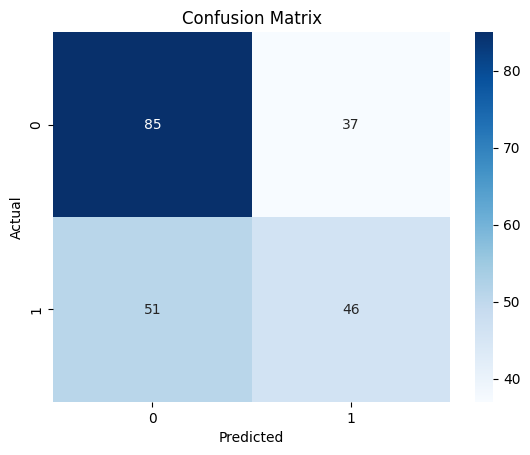

In [124]:
# Evaluate the model

# Model accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Detailed evaluation
print(classification_report(y_test, y_pred))

# Confusion matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

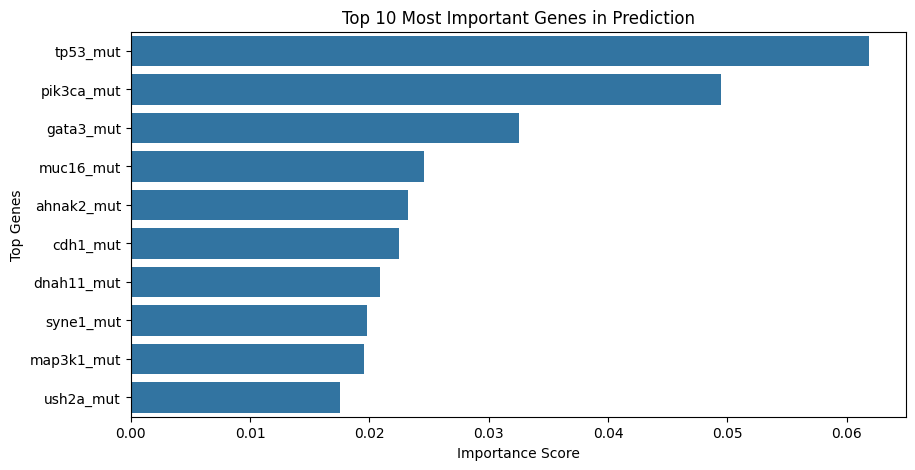

In [125]:
# Feature Importance (Top Genes Contributing to Prediction)

# Get feature importance from Random Forest
feature_importance = pd.DataFrame({'Gene': X.columns, 'Importance': model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False).head(10)

# Plot top 10 important genes
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance['Importance'], y=feature_importance['Gene'])
plt.xlabel("Importance Score")
plt.ylabel("Top Genes")
plt.title("Top 10 Most Important Genes in Prediction")
plt.show()

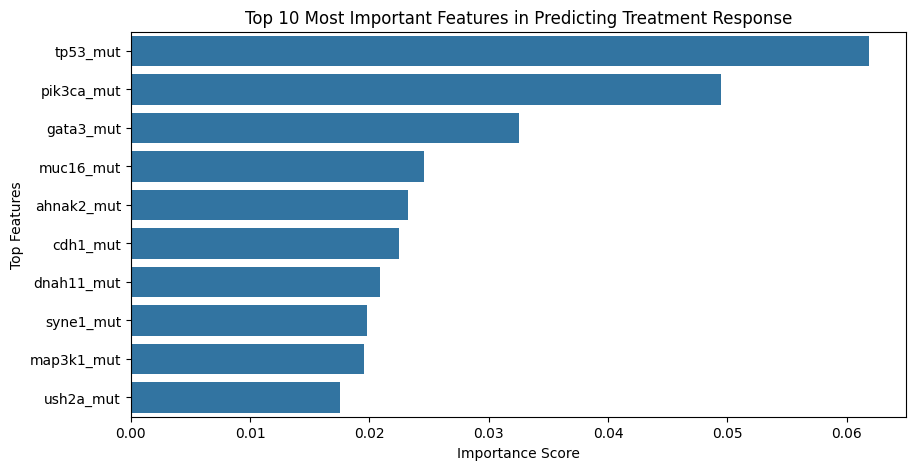

In [127]:
# Get feature importance from Random Forest
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False).head(10)

# Plot top 10 important features
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'])
plt.xlabel("Importance Score")
plt.ylabel("Top Features")
plt.title("Top 10 Most Important Features in Predicting Treatment Response")
plt.show()


In [128]:
# List clinical features to include
clinical_features = ['age_at_diagnosis', 'type_of_breast_surgery', 'chemotherapy', 'pam50_+_claudin-low_subtype']

# Select both gene expression and clinical features
X = df[gene_columns + clinical_features]

# Check if there are any missing values in clinical data
print(df[clinical_features].isnull().sum())


age_at_diagnosis               0
type_of_breast_surgery         0
chemotherapy                   0
pam50_+_claudin-low_subtype    0
dtype: int64


In [133]:
# Encode categorical variables

# For columns like chemotherapy or pam50_+_claudin-low_subtype, you can apply one-hot encoding

# One-Hot Encoding for categorical features (for columns like 'type_of_breast_surgery')
df_encoded = pd.get_dummies(df[clinical_features], drop_first=True)

# Combine the original dataset with the encoded categorical variables
X = pd.concat([df[gene_columns], df_encoded], axis=1)

# Check the new dataset structure
print(X.head())



   pik3ca_mut  tp53_mut  muc16_mut  ahnak2_mut  kmt2c_mut  syne1_mut  \
1   -0.697922  0.389958  -0.394182   -0.382828  -0.309724  -0.310567   
4   -0.697922  2.034372  -0.394182   -0.382828  -0.309724  -0.310567   
5    1.095237  1.323651  -0.394182   -0.382828  -0.309724  -0.310567   
8   -0.697922 -0.292893   2.259416   -0.382828  -0.309724  -0.310567   
9    1.095237 -0.627350  -0.394182   -0.382828   1.664399  -0.310567   

   gata3_mut  map3k1_mut  ahnak_mut  dnah11_mut  ...  siah1_mut  \
1  -0.331151   -0.274713  -0.268405   -0.285635  ...        0.0   
4  -0.331151   -0.274713  -0.268405   -0.285635  ...        0.0   
5  -0.279180   -0.274713  -0.268405   -0.285635  ...        0.0   
8  -0.331151   -0.274713  -0.268405   -0.285635  ...        0.0   
9  -0.331151   -0.274713  -0.268405   -0.285635  ...        0.0   

   age_at_diagnosis  chemotherapy  type_of_breast_surgery_MASTECTOMY  \
1             43.19             0                              False   
4             76.97 

In [134]:
# Check data types of all columns to ensure they're numeric
print(X.dtypes)

pik3ca_mut                                 float64
tp53_mut                                   float64
muc16_mut                                  float64
ahnak2_mut                                 float64
kmt2c_mut                                  float64
                                            ...   
pam50_+_claudin-low_subtype_LumA              bool
pam50_+_claudin-low_subtype_LumB              bool
pam50_+_claudin-low_subtype_NC                bool
pam50_+_claudin-low_subtype_Normal            bool
pam50_+_claudin-low_subtype_claudin-low       bool
Length: 182, dtype: object


In [135]:
# To fix the non-numeric columns

# Find columns that are not numeric
non_numeric_cols = X.select_dtypes(exclude=['number']).columns
print("Non-Numeric Columns:", non_numeric_cols)

Non-Numeric Columns: Index(['type_of_breast_surgery_MASTECTOMY', 'pam50_+_claudin-low_subtype_Her2',
       'pam50_+_claudin-low_subtype_LumA', 'pam50_+_claudin-low_subtype_LumB',
       'pam50_+_claudin-low_subtype_NC', 'pam50_+_claudin-low_subtype_Normal',
       'pam50_+_claudin-low_subtype_claudin-low'],
      dtype='object')


In [136]:
# Convert boolean columns to integers (0/1)
X[non_numeric_cols] = X[non_numeric_cols].astype(int)

In [137]:
# Apply label encoding to object-type columns
label_encoders = {}
for col in non_numeric_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # Save encoders for future use

In [138]:
print(X.dtypes)  # Ensure all columns are now numeric

pik3ca_mut                                 float64
tp53_mut                                   float64
muc16_mut                                  float64
ahnak2_mut                                 float64
kmt2c_mut                                  float64
                                            ...   
pam50_+_claudin-low_subtype_LumA             int64
pam50_+_claudin-low_subtype_LumB             int64
pam50_+_claudin-low_subtype_NC               int64
pam50_+_claudin-low_subtype_Normal           int64
pam50_+_claudin-low_subtype_claudin-low      int64
Length: 182, dtype: object


In [139]:
# All columns are now numeric

In [140]:
# Training  the Random Forest Model:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.68      0.80      0.73       122
           1       0.68      0.54      0.60        97

    accuracy                           0.68       219
   macro avg       0.68      0.67      0.67       219
weighted avg       0.68      0.68      0.67       219



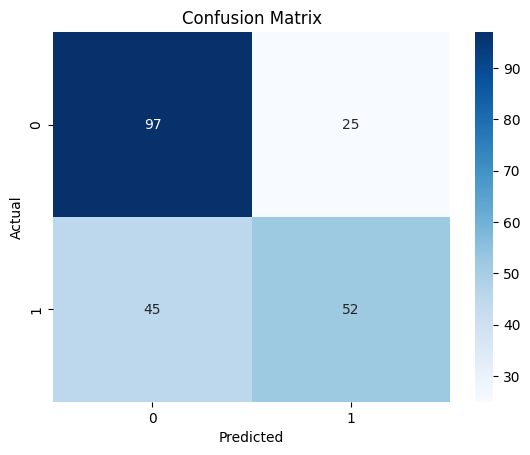

In [141]:
# Evaluate model Performance

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [142]:
# Analyze Feature Importance

# Since the dataset includes gene expressions, mutations, and clinical attributes, let’s identify which features are most important for predicting treatment response.

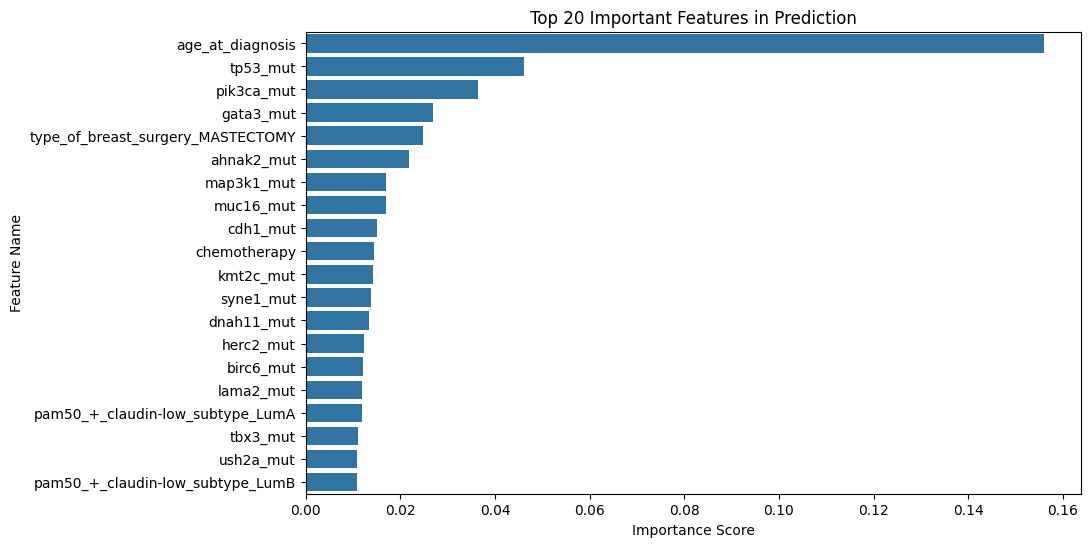

In [151]:
# Get feature importance scores
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})

# Sort by importance (descending)
feature_importance = feature_importance.sort_values(by='Importance', ascending=False).head(20)

# Plot top 20 important features
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'], hue=None, legend=False)
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 20 Important Features in Prediction")
plt.show()

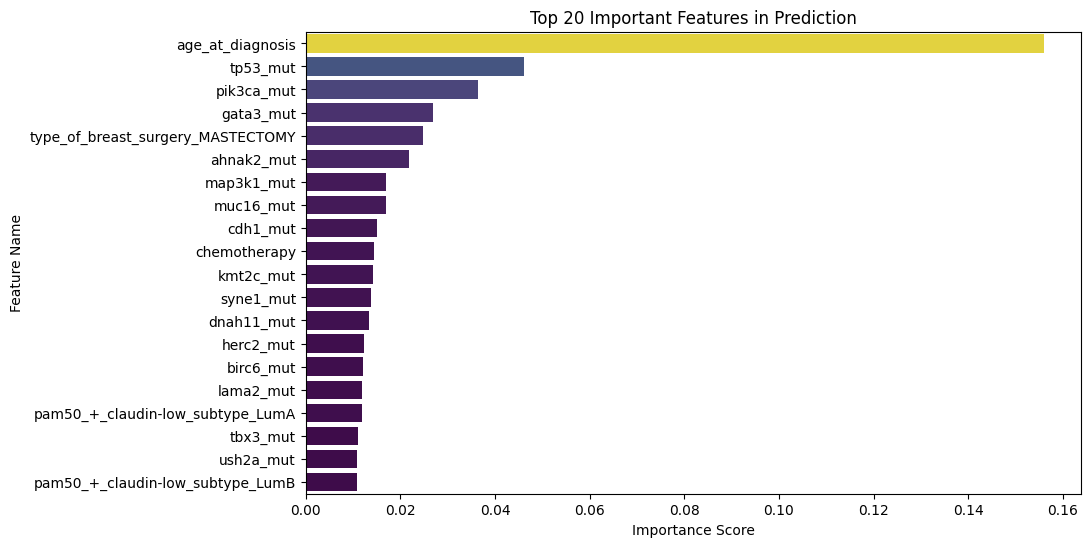

In [156]:
# For coloured visualization

plt.figure(figsize=(10, 6))
sns.barplot(
    x=feature_importance['Importance'], 
    y=feature_importance['Feature'], 
    hue=feature_importance['Importance'],  # Assign hue based on importance values
    palette='viridis', 
    dodge=False  # Avoid duplicate bars due to hue
)
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 20 Important Features in Prediction")
plt.legend([], [], frameon=False)  # Hide legend
plt.show()

In [144]:
# What does it tell?
# The top-ranked features are the most influential in predicting treatment response.
# Check if clinical attributes (e.g., chemotherapy, age at diagnosis, PAM50 subtypes) are more important than specific gene mutations.
# If certain genes or clinical factors have very low importance, they may not be useful.

In [153]:
# Save the trained model
import joblib

joblib.dump(model, "cancer_treatment_model.pkl")

# Save the scaler for preprocessing future data
joblib.dump(scaler, "scaler.pkl")

print("Model and scaler saved successfully.")


Model and scaler saved successfully.


In [154]:
# Save feature importance
feature_importance.to_csv("feature_importance.csv", index=False)
print("Feature importance saved successfully.")


Feature importance saved successfully.


In [155]:
# Save evaluation metrics
with open("model_evaluation.txt", "w") as f:
    f.write(f"Accuracy: {accuracy:.2f}\n")
    f.write("\nClassification Report:\n")
    f.write(classification_report(y_test, y_pred))
    f.write("\nConfusion Matrix:\n")
    f.write(np.array2string(confusion_matrix(y_test, y_pred)))

print("Model evaluation results saved successfully.")


Model evaluation results saved successfully.
